In [1]:
class_labels = [ 'attack' , 'real' ]
label2id = { label : i for i , label in enumerate(class_labels) }
id2label = { i : label for label , i in label2id.items( ) }

In [2]:
from transformers import VideoMAEImageProcessor , VideoMAEForVideoClassification

model_ckpt = "MCG-NJU/videomae-base"
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
        model_ckpt ,
        label2id=label2id ,
        id2label=id2label ,
        ignore_mismatched_sizes=True ,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

/Users/jonathansuru/anaconda3/envs/OpenVerify/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey ,
    Normalize ,
    RandomShortSideScale ,
    RemoveKey ,
    ShortSideScale ,
    UniformTemporalSubsample ,
)

from torchvision.transforms import (
    Compose ,
    Lambda ,
    RandomCrop ,
    RandomHorizontalFlip ,
    Resize ,
)

In [4]:
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size :
    height = width = image_processor.size[ "shortest_edge" ]
else :
    height = image_processor.size[ "height" ]
    width = image_processor.size[ "width" ]
resize_to = (height , width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

In [5]:
train_transform = Compose(
        [
                ApplyTransformToKey(
                        key="video" ,
                        transform=Compose(
                                [
                                        UniformTemporalSubsample(num_frames_to_sample) ,
                                        Lambda(lambda x : x / 255.0) ,
                                        Normalize(mean , std) ,
                                        RandomShortSideScale(min_size=256 , max_size=320) ,
                                        RandomCrop(resize_to) ,
                                        RandomHorizontalFlip(p=0.5) ,
                                ]
                        ) ,
                ) ,
        ]
)

In [6]:
import os

dataset_root_path = "datasets/data"
train_dataset = pytorchvideo.data.Ucf101(
        data_path=os.path.join(dataset_root_path , "train") ,
        clip_sampler=pytorchvideo.data.make_clip_sampler("random" , clip_duration) ,
        decode_audio=False ,
        transform=train_transform ,
)

In [7]:
val_transform = Compose(
        [
                ApplyTransformToKey(
                        key="video" ,
                        transform=Compose(
                                [
                                        UniformTemporalSubsample(num_frames_to_sample) ,
                                        Lambda(lambda x : x / 255.0) ,
                                        Normalize(mean , std) ,
                                        Resize(resize_to) ,
                                ]
                        ) ,
                ) ,
        ]
)

val_dataset = pytorchvideo.data.Ucf101(
        data_path=os.path.join(dataset_root_path , "val") ,
        clip_sampler=pytorchvideo.data.make_clip_sampler("uniform" , clip_duration) ,
        decode_audio=False ,
        transform=val_transform ,
)

test_dataset = pytorchvideo.data.Ucf101(
        data_path=os.path.join(dataset_root_path , "test") ,
        clip_sampler=pytorchvideo.data.make_clip_sampler("uniform" , clip_duration) ,
        decode_audio=False ,
        transform=val_transform ,
)

In [8]:
print(train_dataset.num_videos , val_dataset.num_videos , test_dataset.num_videos)


256 65 81


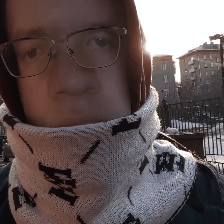

In [9]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img) :
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0 , 255)


def create_gif(video_tensor , filename="sample.gif") :
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = [ ]
    for video_frame in video_tensor :
        frame_unnormalized = unnormalize_img(video_frame.permute(1 , 2 , 0).numpy( ))
        frames.append(frame_unnormalized)
    kargs = { "duration" : 0.25 }
    imageio.mimsave(filename , frames , "GIF" , **kargs)
    return filename


def display_gif(video_tensor , gif_name="sample.gif") :
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1 , 0 , 2 , 3)
    gif_filename = create_gif(video_tensor , gif_name)
    return Image(filename=gif_filename)


sample_video = next(iter(train_dataset))
video_tensor = sample_video[ "video" ]
display_gif(video_tensor)

In [10]:
from transformers import TrainingArguments , Trainer

model_name = model_ckpt.split("/")[ -1 ]
new_model_name = f"{model_name}-finetuned-anti-spoofing"
num_epochs = 4
batch_size = 32

args = TrainingArguments(
        new_model_name ,
        remove_unused_columns=False ,
        eval_strategy="epoch" ,
        save_strategy="epoch" ,
        learning_rate=5e-5 ,
        per_device_train_batch_size=batch_size ,
        per_device_eval_batch_size=batch_size ,
        warmup_ratio=0.1 ,
        logging_steps=10 ,
        load_best_model_at_end=True ,
        metric_for_best_model="accuracy" ,
        push_to_hub=True ,
        max_steps=(train_dataset.num_videos // batch_size) * num_epochs ,
)

In [11]:
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred) :
    predictions = np.argmax(eval_pred.predictions , axis=1)
    return metric.compute(predictions=predictions , references=eval_pred.label_ids)

In [12]:
import torch


def collate_fn(examples) :
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
            [ example[ "video" ].permute(1 , 0 , 2 , 3) for example in examples ]
    )
    labels = torch.tensor([ example[ "label" ] for example in examples ])
    return { "pixel_values" : pixel_values , "labels" : labels }

In [13]:
trainer = Trainer(
        model ,
        args ,
        train_dataset=train_dataset ,
        eval_dataset=val_dataset ,
        tokenizer=image_processor ,
        compute_metrics=compute_metrics ,
        data_collator=collate_fn ,
)

max_steps is given, it will override any value given in num_train_epochs


In [14]:
train_results = trainer.train( )

RuntimeError: MPS backend out of memory (MPS allocated: 15.49 GB, other allocations: 10.64 MB, max allowed: 18.13 GB). Tried to allocate 3.52 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).